In [2]:
!pip install gdown

In [3]:
!gdown --folder 1dDHe9rGbbcQj5g-i7AAPzCVxA-Dr0v5s

Retrieving folder contents
Processing file 1TEp3zs7RUwP8vgBaqPrRxT2N35kDnVw6 credits.csv
Processing file 1eMxBVq5YWbfMFxK-B5m9jCk5ieOuuqIS keywords.csv
Processing file 1BQpHhKWmXPxlHcozTd2ofttMMoTAXRWL links_small.csv
Processing file 1mIgrz_OcHoX02mHdAM4tg2KRJGqqTkp6 links.csv
Processing file 1Bg2y5CfcwvDo8IbXt1YOUukH7aT9UT1c movies_metadata.csv
Processing file 1TCueo42H6SnCexPq4MaeF-cKg5rJH_jT Project Movie Analytics by Dims.ipynb
Processing file 1RhFcWBV1uR8wUors9RRM6mRtpJbTt2-k ratings_small.csv
Processing file 15jrvOpQ5rJSChkMyFER_FOBL23EXqx4Y ratings.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1TEp3zs7RUwP8vgBaqPrRxT2N35kDnVw6
From (redirected): https://drive.google.com/uc?id=1TEp3zs7RUwP8vgBaqPrRxT2N35kDnVw6&confirm=t&uuid=40649625-da65-47c5-89f2-491fcf9a3e3a
To: /content/Project 1/credits.csv
100% 190M/190M [00:03<00:00, 62.5MB/s]
Downloading...
From: h

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import joblib

sns.set_theme(style="whitegrid")
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12})

In [5]:
ratings = pd.read_csv('/content/Project 1/ratings.csv')
movies = pd.read_csv('/content/Project 1/movies_metadata.csv')
credits = pd.read_csv('/content/Project 1/credits.csv')
keywords = pd.read_csv('/content/Project 1/keywords.csv')

/tmp/ipython-input-1577304877.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('/content/Project 1/movies_metadata.csv')


In [6]:
print(f"Ratings: {ratings.shape}, Movies: {movies.shape}, Credits: {credits.shape}, Keywords: {keywords.shape}")

Ratings: (26024289, 4), Movies: (45466, 24), Credits: (45476, 3), Keywords: (46419, 2)


In [7]:
def missing_percentage(df, name):
  missing = df.isna().sum()/len(df)*100
  print(f"{name} Missing values: ")
  print(missing[missing > 0].sort_values(ascending=False))

missing_percentage(ratings, "Ratings")
missing_percentage(movies, "Movies")
missing_percentage(credits, "Credits")
missing_percentage(keywords, "Keywords")

Ratings Missing values: 
Series([], dtype: float64)
Movies Missing values: 
belongs_to_collection    90.115691
homepage                 82.883913
tagline                  55.104914
overview                  2.098271
poster_path               0.848986
runtime                   0.578454
release_date              0.191352
status                    0.191352
imdb_id                   0.037391
original_language         0.024194
revenue                   0.013197
title                     0.013197
video                     0.013197
vote_average              0.013197
spoken_languages          0.013197
vote_count                0.013197
popularity                0.010997
production_companies      0.006598
production_countries      0.006598
dtype: float64
Credits Missing values: 
Series([], dtype: float64)
Keywords Missing values: 
Series([], dtype: float64)


In [8]:
movies.drop(columns=['belongs_to_collection', 'homepage', 'tagline'], inplace=True, errors='ignore')

In [9]:
numeric_cols = ['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']
for col in numeric_cols:
  movies[col] = pd.to_numeric(movies[col], errors='coerce')

movies[numeric_cols] = movies[numeric_cols].fillna(movies[numeric_cols].median())

In [10]:
text_cols = ['overview', 'poster_path', 'release_date', 'status',
             'imdb_id', 'original_language', 'production_companies', 'production_countries']

for col in text_cols:
  if col in movies.columns:
    movies[col] = movies[col].fillna('Unknown')

In [11]:
print(movies.isna().sum().sort_values(ascending=False).head(10))

title                6
video                6
spoken_languages     6
budget               0
adult                0
imdb_id              0
id                   0
genres               0
original_language    0
poster_path          0
dtype: int64


In [12]:
movies['title'] = movies['title'].fillna('Unknown')
movies['video'] = movies['video'].fillna('False')
movies['spoken_languages'] = movies['spoken_languages'].fillna('Unknown')

movies.dropna(subset=['title'], inplace=True)

print(movies.isna().sum().sort_values(ascending=False).head(10))

adult                0
budget               0
genres               0
id                   0
imdb_id              0
original_language    0
original_title       0
overview             0
popularity           0
poster_path          0
dtype: int64


In [13]:
movies.drop_duplicates(subset='id', inplace=True)
ratings.drop_duplicates(inplace=True)
ratings.fillna(0, inplace=True)

In [14]:
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
ratings['movieId'] = pd.to_numeric(ratings['movieId'], errors='coerce')

df_merged = ratings.merge(movies, left_on='movieId', right_on='id', how='inner')

In [15]:
df_merged.head()

,userId,movieId,rating,timestamp,adult,budget,genres,id,imdb_id,original_language,...,production_countries,release_date,revenue,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,1,110,1.0,1425941529,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 9648, 'na...",110.0,tt0111495,fr,...,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",1994-05-27,0.0,99.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,Three Colors: Red,False,7.8,246.0
1,1,147,4.5,1425942435,False,0.0,"[{'id': 18, 'name': 'Drama'}]",147.0,tt0053198,fr,...,"[{'iso_3166_1': 'FR', 'name': 'France'}]",1959-05-04,0.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The 400 Blows,False,8.0,363.0
2,1,858,5.0,1425941523,False,21000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",858.0,tt0108160,en,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1993-06-24,227799884.0,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Sleepless in Seattle,False,6.5,630.0
3,1,1246,5.0,1425941556,False,24000000.0,"[{'id': 18, 'name': 'Drama'}]",1246.0,tt0479143,en,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-12-20,155721132.0,102.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Rocky Balboa,False,6.5,858.0
4,1,1968,4.0,1425942148,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",1968.0,tt0119141,en,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-02-14,29481428.0,109.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fools Rush In,False,5.8,133.0


In [16]:
scaler = StandardScaler()
num_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count']
df_merged_std = df_merged.copy()

df_merged_std[num_features] = scaler.fit_transform(df_merged[num_features])

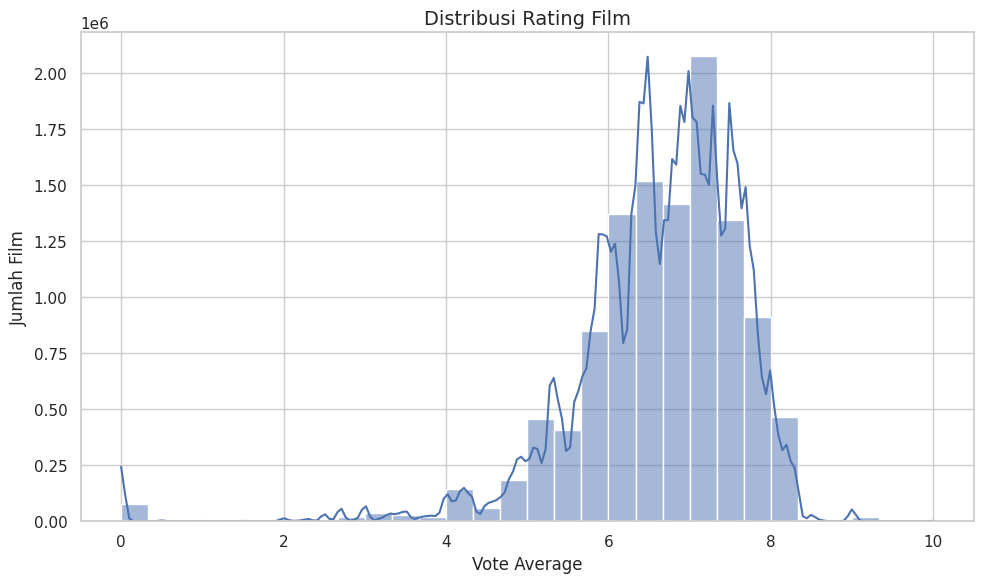

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(df_merged['vote_average'], bins=30, kde=True, color="#4C72B0")
plt.title("Distribusi Rating Film")
plt.xlabel("Vote Average")
plt.ylabel("Jumlah Film")
plt.tight_layout()
plt.show()

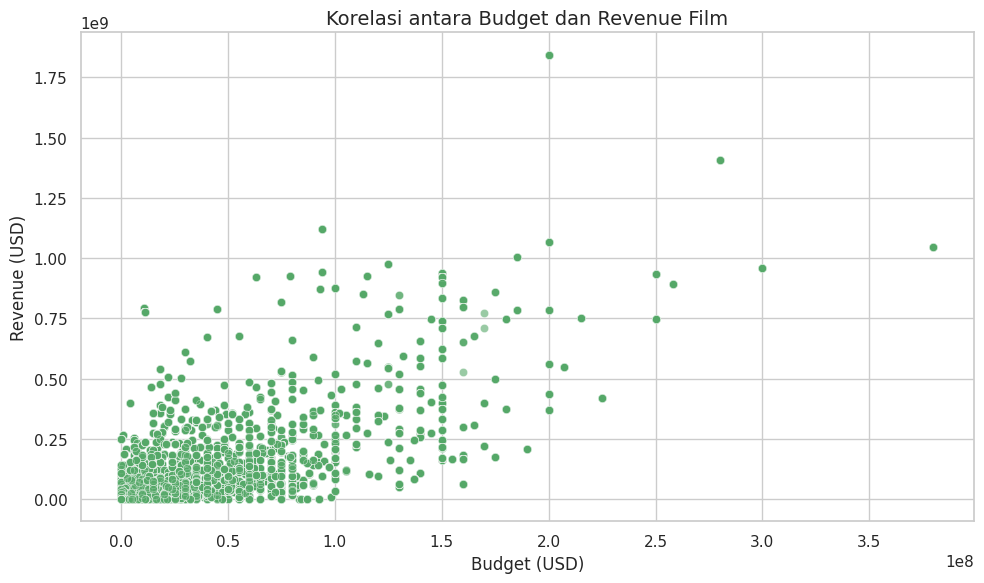

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='budget',
    y='revenue',
    data=df_merged,
    alpha=0.6,
    color="#55A868"
)
plt.title("Korelasi antara Budget dan Revenue Film")
plt.xlabel("Budget (USD)")
plt.ylabel("Revenue (USD)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-177936806.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


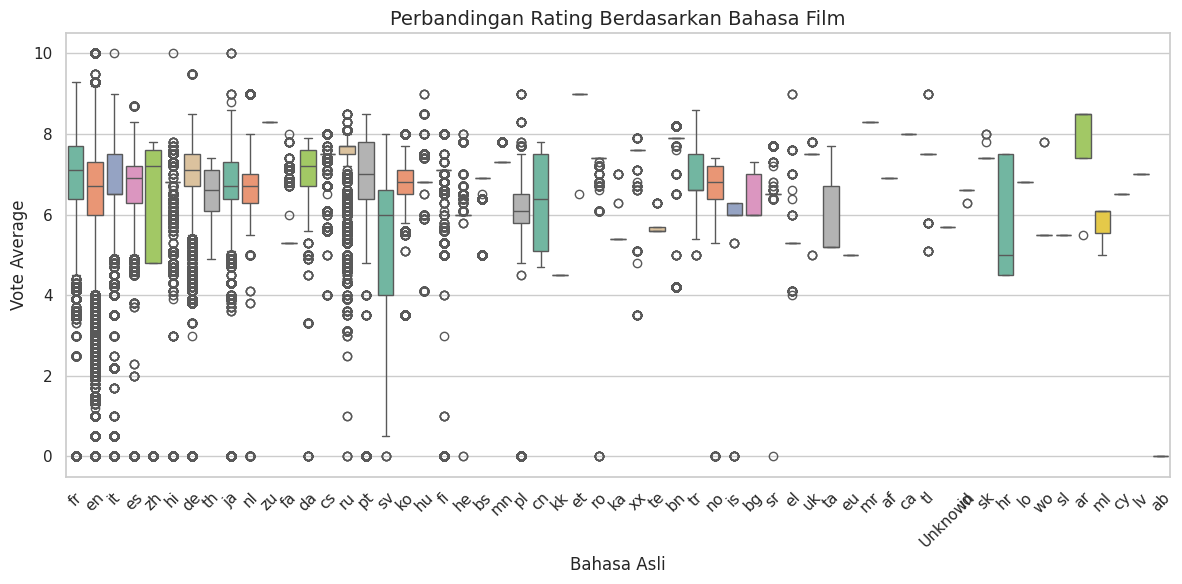

In [19]:
plt.figure(figsize=(12,6))
sns.boxplot(
    x='original_language',
    y='vote_average',
    data=df_merged,
    palette='Set2'
)
plt.title("Perbandingan Rating Berdasarkan Bahasa Film")
plt.xlabel("Bahasa Asli")
plt.ylabel("Vote Average")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

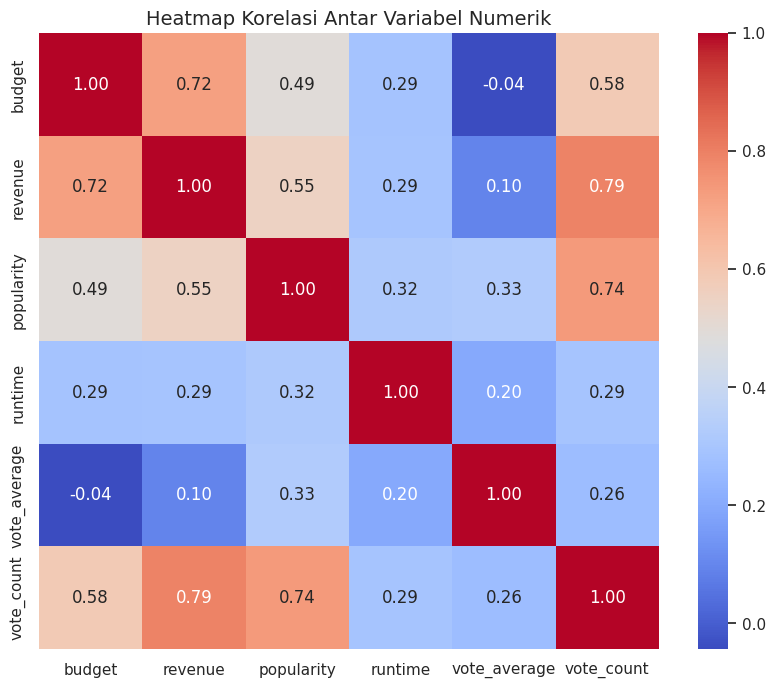

In [20]:
plt.figure(figsize=(10,8))
corr = df_merged[num_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap Korelasi Antar Variabel Numerik")
plt.show()

/tmp/ipython-input-1833583596.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=movies['main_genre'], order=movies['main_genre'].value_counts().index, palette='viridis')


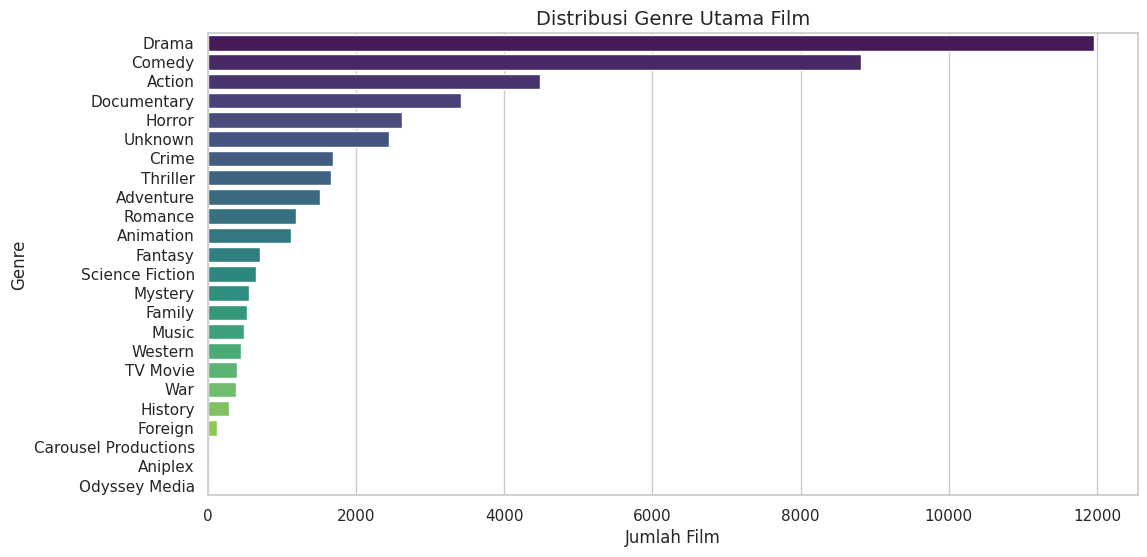

In [21]:
def extract_main_genre(genre_list):
    if isinstance(genre_list, str):
        genre_list = eval(genre_list)
    if genre_list:
        return genre_list[0]['name']
    return 'Unknown'

movies['main_genre'] = movies['genres'].apply(extract_main_genre)

plt.figure(figsize=(12,6))
sns.countplot(y=movies['main_genre'], order=movies['main_genre'].value_counts().index, palette='viridis')
plt.title("Distribusi Genre Utama Film")
plt.xlabel("Jumlah Film")
plt.ylabel("Genre")
plt.show()

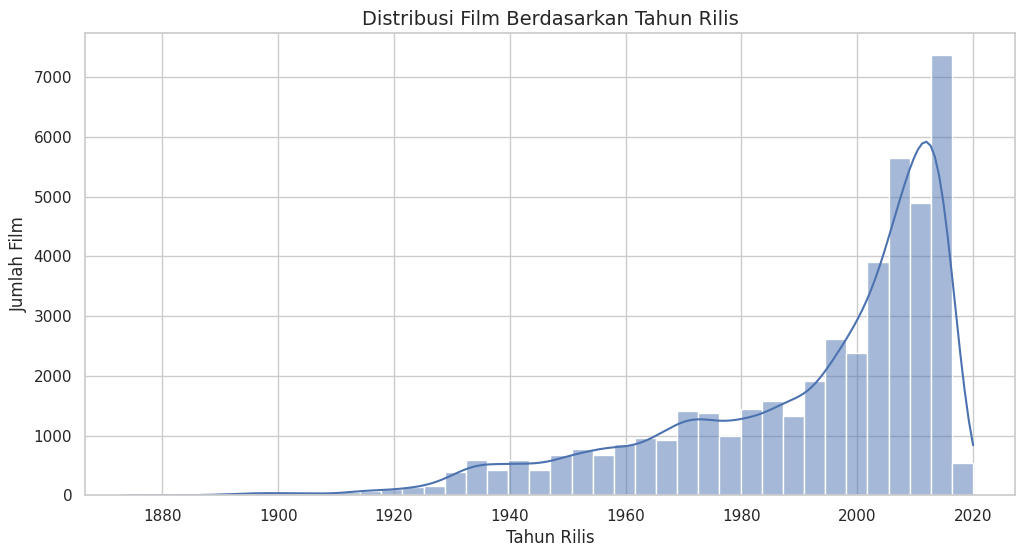

In [22]:
movies['release_year'] = pd.to_datetime(movies['release_date'], errors='coerce').dt.year
plt.figure(figsize=(12,6))
sns.histplot(movies['release_year'].dropna(), bins=40, kde=True)
plt.title("Distribusi Film Berdasarkan Tahun Rilis")
plt.xlabel("Tahun Rilis")
plt.ylabel("Jumlah Film")
plt.show()

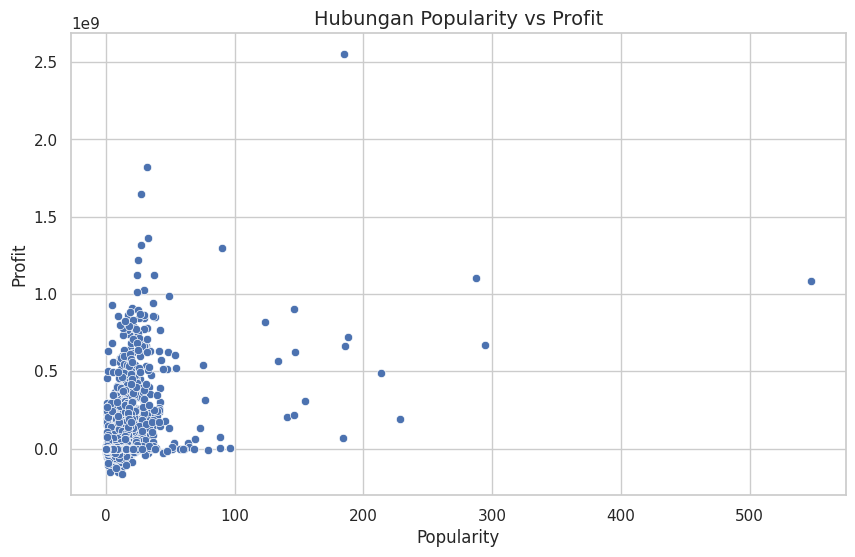

In [23]:
movies['profit'] = movies['revenue'] - movies['budget']
plt.figure(figsize=(10,6))
sns.scatterplot(x='popularity', y='profit', data=movies)
plt.title("Hubungan Popularity vs Profit")
plt.xlabel("Popularity")
plt.ylabel("Profit")
plt.show()

In [24]:
num_for_corr = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count', 'runtime', 'profit']
print(movies[num_for_corr].corr()['profit'].sort_values(ascending=False))

profit          1.000000
revenue         0.976904
vote_count      0.775771
budget          0.614432
popularity      0.474320
runtime         0.083220
vote_average    0.078933
Name: profit, dtype: float64


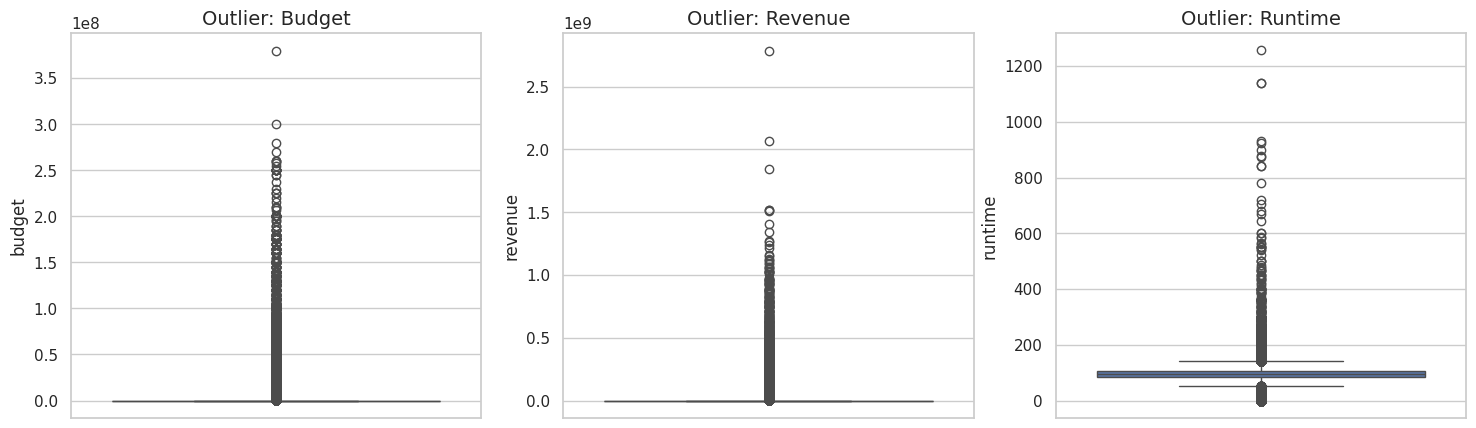

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.boxplot(y=movies['budget'], ax=axes[0])
axes[0].set_title('Outlier: Budget')
sns.boxplot(y=movies['revenue'], ax=axes[1])
axes[1].set_title('Outlier: Revenue')
sns.boxplot(y=movies['runtime'], ax=axes[2])
axes[2].set_title('Outlier: Runtime')
plt.show()

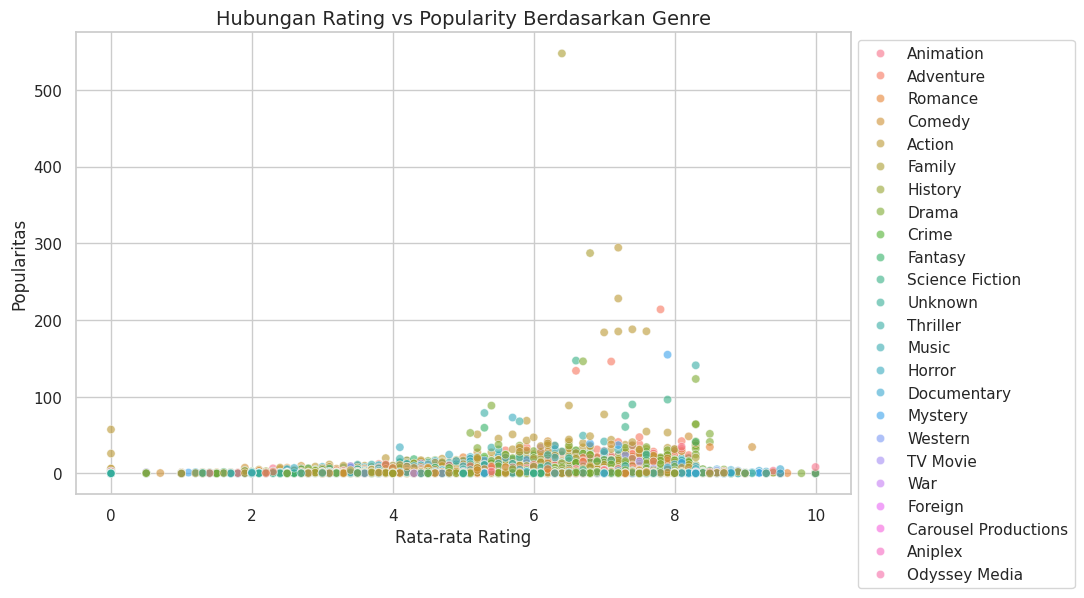

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='vote_average', y='popularity', hue='main_genre', data=movies, alpha=0.6)
plt.title("Hubungan Rating vs Popularity Berdasarkan Genre")
plt.xlabel("Rata-rata Rating")
plt.ylabel("Popularitas")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [27]:
movies['profit'] = movies['revenue'] - movies['budget']
movies['is_english'] = movies['original_language'].apply(lambda x: 1 if x == 'en' else 0)
movies['title_len'] = movies['title'].apply(lambda x: len(str(x)))
movies['duration_hours'] = movies['runtime'] / 60
movies['favorite_movie'] = movies['vote_average'].apply(lambda x: 1 if x >= 7 else 0)
def extract_first_genre(x):
  try:
    genres = ast.literal_eval(x)
    return genres[0]['name'] if isinstance(genres, list) and len(genres) > 0 else 'Unknown'
  except:
    return 'Unknown'
movies['main_genre'] = movies['genres'].apply(extract_first_genre)

In [28]:
display(movies[['title', 'main_genre', 'budget', 'revenue', 'profit',
                'is_english', 'title_len', 'duration_hours', 'favorite_movie']].head())

,title,main_genre,budget,revenue,profit,is_english,title_len,duration_hours,favorite_movie
0,Toy Story,Animation,30000000.0,373554033.0,343554033.0,1,9,1.350000,1
1,Jumanji,Adventure,65000000.0,262797249.0,197797249.0,1,7,1.733333,0
2,Grumpier Old Men,Romance,0.0,0.0,0.0,1,16,1.683333,0
3,Waiting to Exhale,Comedy,16000000.0,81452156.0,65452156.0,1,17,2.116667,0
4,Father of the Bride Part II,Comedy,0.0,76578911.0,76578911.0,1,27,1.766667,0


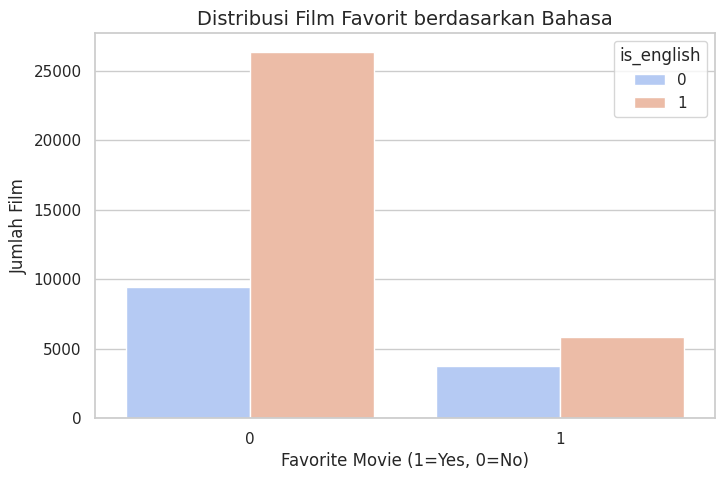

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(x='favorite_movie', hue='is_english', data=movies, palette='coolwarm')
plt.title("Distribusi Film Favorit berdasarkan Bahasa")
plt.xlabel("Favorite Movie (1=Yes, 0=No)")
plt.ylabel("Jumlah Film")
plt.show()

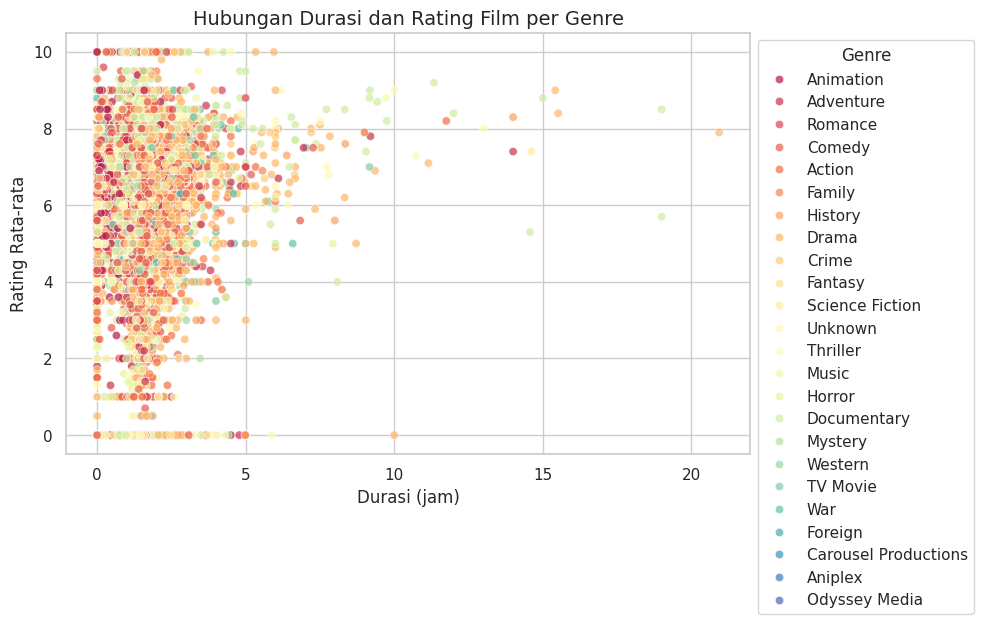

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='duration_hours',
    y='vote_average',
    hue='main_genre',
    data=movies,
    alpha=0.7,
    palette='Spectral'
)
plt.title("Hubungan Durasi dan Rating Film per Genre")
plt.xlabel("Durasi (jam)")
plt.ylabel("Rating Rata-rata")
plt.legend(bbox_to_anchor=(1, 1), title="Genre")
plt.tight_layout()
plt.show()

In [31]:
movies['overview'] = movies['overview'].fillna('')

tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(movies['overview'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)
movies['topic'] = lda_topics.argmax(axis=1)

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (45436, 5000)


In [32]:
df_model = movies.copy()
df_model = df_model.dropna(subset=['vote_average', 'profit', 'favorite_movie'])

features = ['budget', 'revenue', 'popularity', 'runtime',
            'title_len', 'duration_hours', 'is_english', 'main_genre']

le = LabelEncoder()
df_model['main_genre_encoded'] = le.fit_transform(df_model['main_genre'])

features = ['budget', 'revenue', 'popularity', 'runtime',
            'title_len', 'duration_hours', 'is_english',
            'main_genre_encoded', 'topic']

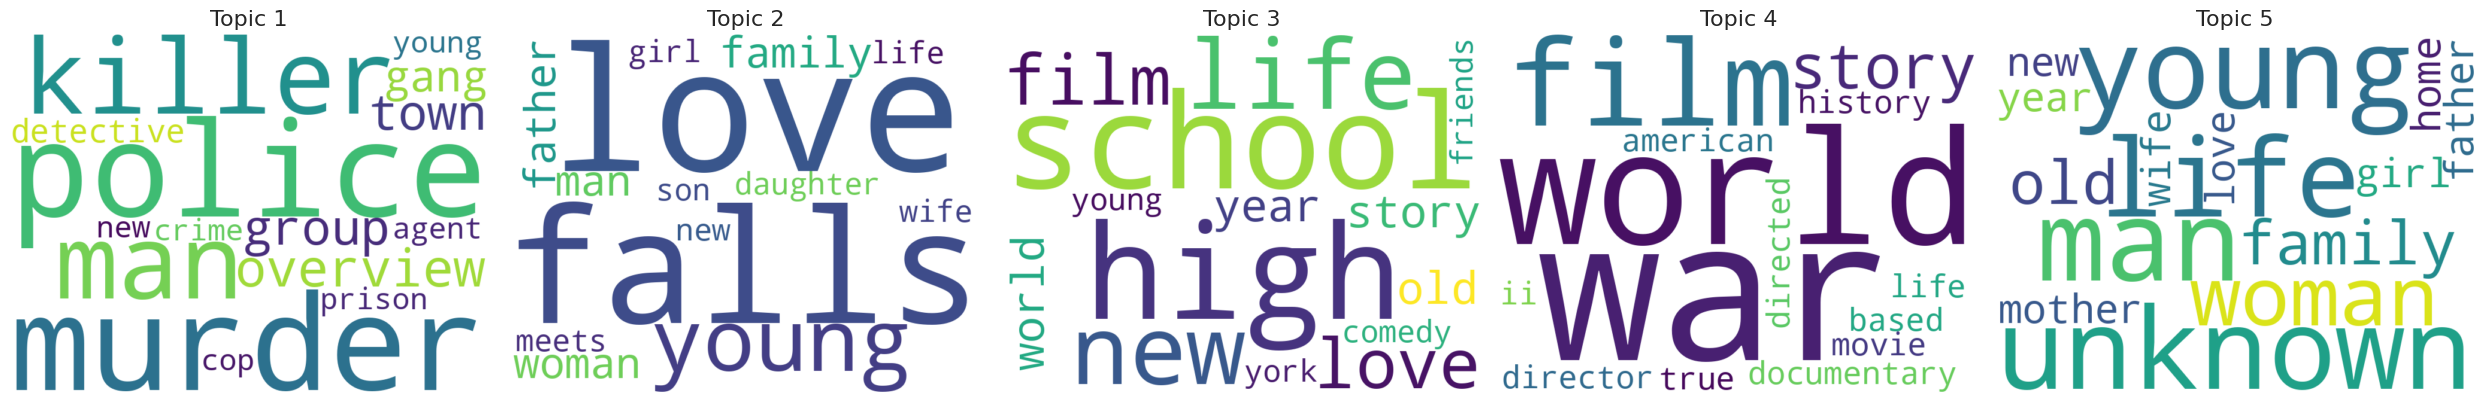

In [33]:
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(top_features)
    return topics

tfidf_feature_names = tfidf.get_feature_names_out()
topics_words = display_topics(lda, tfidf_feature_names, 15)

fig, axes = plt.subplots(1, 5, figsize=(25, 12))
for i, ax in enumerate(axes.flat):
    topic_words = topics_words[i]
    text = " ".join(topic_words)
    wc = WordCloud(width=800, height=600, background_color='white', colormap='viridis').generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Topic {i+1}", fontsize=16)

plt.tight_layout()
plt.show()

In [34]:
X = df_model[features]
y_class = df_model['favorite_movie']
y_reg = df_model['profit']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)

In [35]:
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)

acc = accuracy_score(y_test_c, y_pred_c)
print(f"Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test_c, y_pred_c))

Accuracy: 0.7936

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.88      7181
           1       0.59      0.05      0.10      1907

    accuracy                           0.79      9088
   macro avg       0.69      0.52      0.49      9088
weighted avg       0.75      0.79      0.72      9088



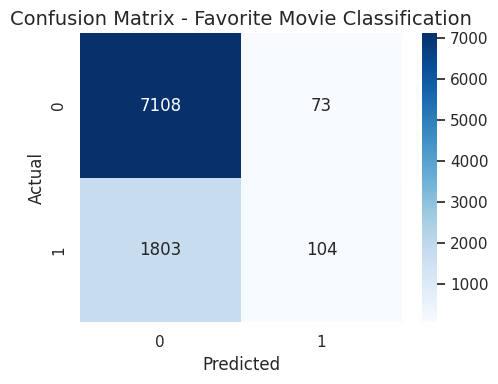

In [36]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_c, y_pred_c), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Favorite Movie Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [37]:
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_r, y_train_r)
y_pred_r = reg.predict(X_test_r)

mae = mean_absolute_error(y_test_r, y_pred_r)
mse = mean_squared_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)

print(f"MAE: {mae:,.2f}")
print(f"MSE: {mse:,.2f}")
print(f"R² Score: {r2:.4f}")

MAE: 222,896.78
MSE: 7,382,976,408,225.36
R² Score: 0.9970


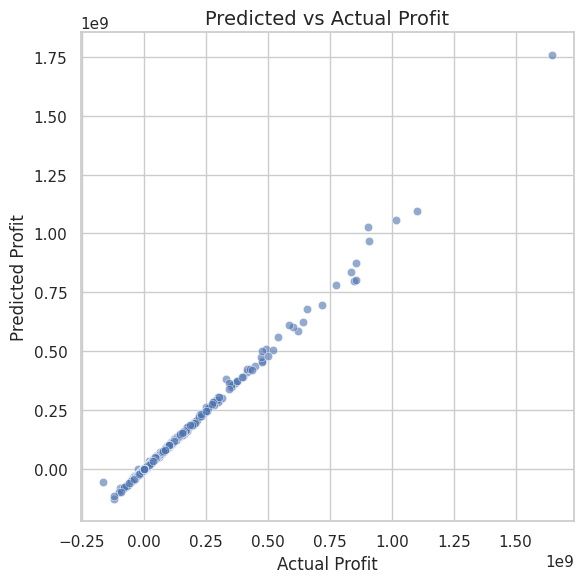

In [38]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test_r, y=y_pred_r, alpha=0.6)
plt.title("Predicted vs Actual Profit")
plt.xlabel("Actual Profit")
plt.ylabel("Predicted Profit")
plt.tight_layout()
plt.show()

In [39]:
feat_imp_clf = pd.DataFrame({
    'Feature': features,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feat_imp_reg = pd.DataFrame({
    'Feature': features,
    'Importance': reg.feature_importances_
}).sort_values(by='Importance', ascending=False)

/tmp/ipython-input-642600341.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_clf, palette='coolwarm')


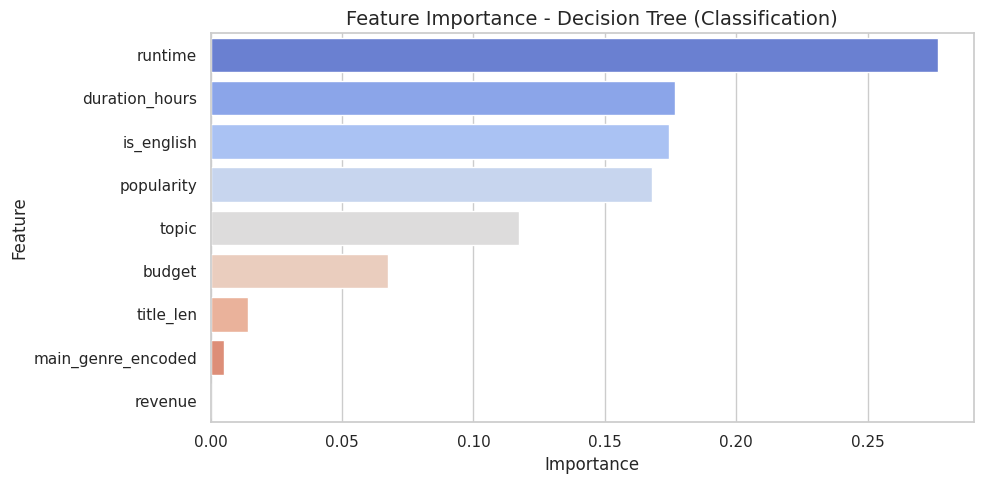

In [40]:
plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_clf, palette='coolwarm')
plt.title("Feature Importance - Decision Tree (Classification)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3578436213.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_reg, palette='mako')


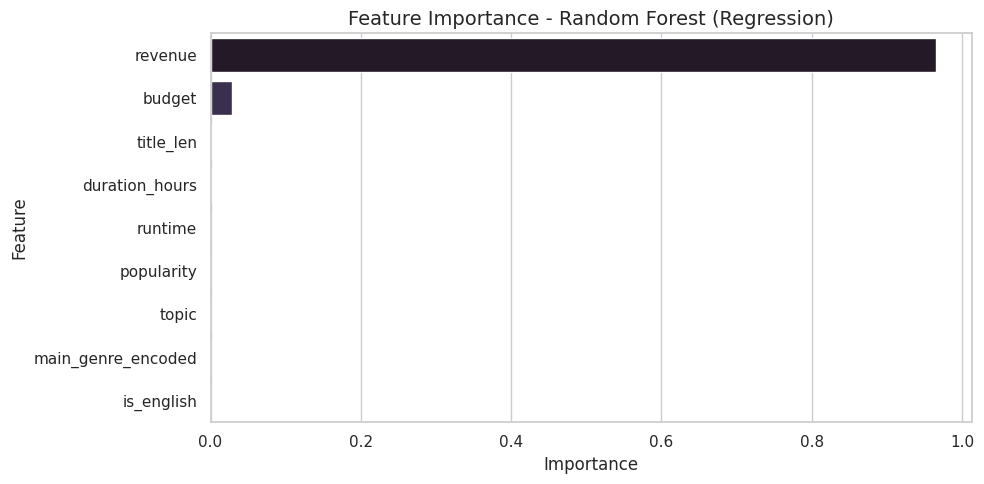

In [41]:
plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_reg, palette='mako')
plt.title("Feature Importance - Random Forest (Regression)")
plt.tight_layout()
plt.show()

In [42]:
df_results = df_model.copy()
df_results['favorite_movie_pred'] = clf.predict(X)

df_results.to_csv("movie_model_results.csv", index=False)

In [43]:
joblib.dump(clf, "favorite_movie_model.pkl")
joblib.dump(reg, "profit_regressor.pkl")

['profit_regressor.pkl']